In [2]:
from ipyparallel import Client

In [5]:
My_Cluster = Client()

In [6]:
My_View = My_Cluster[:]

In [7]:
print (My_View)
print (len(My_View))

<DirectView [0, 1, 2, 3,...]>
10


In [8]:
# turn on plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
#utilities for interacting with the OS
import os

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [9]:
"""
pyart.retrieve.quasi_vertical_profile
=====================================

Retrieval of QVPs from a radar object

.. autosummary::
    :
    :
    
    quasi_vertical_profile
"""

#import numpy as np

#from pyart.io import read
#from pyart.core import antenna_to_cartesian



def quasi_vertical_profile(filename, fields=None, gatefilter=None):
    
    """
    Quasi Vertical Profile.
    
    Creates a QVP object ....
    
    
    Parameters
    ----------
    radar : Radar
        Radar object used.
    field : string
        Radar field to use for QVP calculation.
    
    Other Parameters
    ----------------
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the import qvp calculation
        
    Returns
    -------
    qvp : 
    
    
    References
    ----------
    Troemel, S., M. Kumjian, A. Ryzhkov, and C. Simmer, 2013: Backscatter 
    differential phase – estimation and variability. J. Appl. Meteor. Clim.. 
    52, 2529 – 2548.

    Troemel, S., A. Ryzhkov, P. Zhang, and C. Simmer, 2014: Investigations 
    of backscatter differential phase in the melting layer. J. Appl. Meteorol. 
    Clim. 53, 2344 – 2359.

    Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Troemel, 
    C. Simmer, 2015: Quasi-vertical profiles – a new way to look at polarimetric 
    radar data. Submitted to J. Atmos. Oceanic Technol.
    
    """
    
    radar = pyart.io.read(filename)
    
    if fields is None:
        fields = radar.fields
        
    #if gatefilter is not None:
        
        
    desired_angle = 20.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    print(radar.fixed_angle['data'])
    print(radar.elevation['data'][-1])
    
    qvp = {}
    
    for field in fields:
        this_field = radar.get_field(index, field).mean(axis = 0)
        qvp.update({field:this_field})
    
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = pyart.core.antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                 radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    #del radar
    return qvp

In [10]:
indir = '/lcrc/group/earthscience/radar/xsapr_sgp/vads/20171004/'
all_xsapr_files = os.listdir(indir)
all_xsapr_files.sort()
interesting_files = []
for fn in all_xsapr_files:
    if 'I5' in fn:
        interesting_files.append(indir + fn)

In [11]:
#radar = read(interesting_files[1])

In [12]:
interesting_files.sort()
print (len(interesting_files))
qvp = quasi_vertical_profile(interesting_files[-1])

144
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.952393


In [13]:
#Turn off blocking so all engines can work async
My_View.block = False

#on all engines do an import of Py-ART
My_View.execute('import pyart')

#Map the code and input to all workers
result = My_View.map_async(quasi_vertical_profile, 
                           interesting_files[:])

#Reduce the result to get a list of output
qvps = result.get()

Text(0, 0.5, 'Height Above Ground (km)')

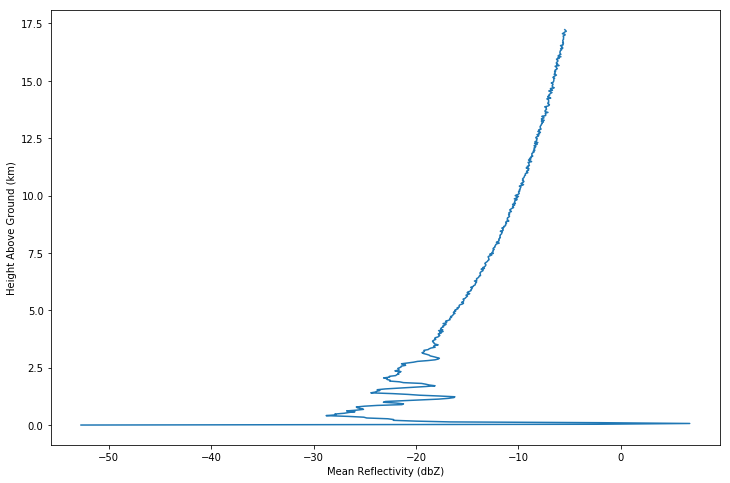

In [14]:
fig = plt.figure(figsize=(12,8))
plt.plot(qvps[143]['reflectivity'], qvps[143]['height']/1000.0)
plt.xlabel('Mean Reflectivity (dbZ)')
plt.ylabel('Height Above Ground (km)')

In [15]:
qvp.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase', 'range', 'time', 'height'])

In [29]:
time_series = {}

n_times = len(qvps)

for fld in ['total_power', 'reflectivity', 'velocity', 
            'spectrum_width', 'differential_reflectivity', 
            'specific_differential_phase', 'cross_correlation_ratio', 
            'normalized_coherent_power', 'differential_phase']:
    this_fld = np.zeros([n_times, len(qvps[0][fld])])
    
    times = np.zeros(n_times)
    
    for i in range(n_times):
        dateobj = num2date(qvps[i]['time']['data'][0], 
                           qvps[i]['time']['units'])
        
        times[i] = mdates.date2num(dateobj)
        
        this_fld[i,:] = qvps[i][fld]
        
    time_series.update({fld: this_fld[times.argsort(), :]})

times.sort()

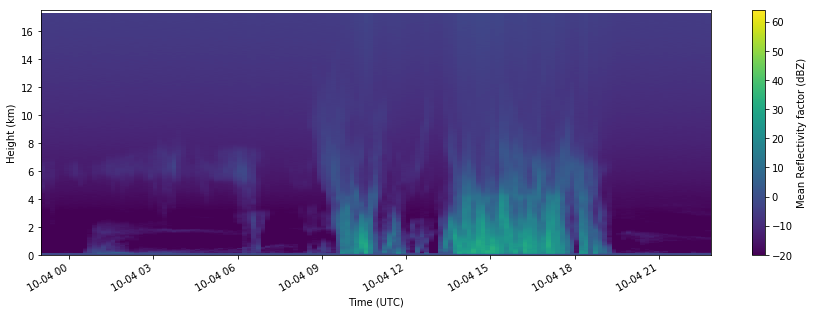

In [27]:
fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(times, qvps[0]['height']/1000.0, 
                    time_series['reflectivity'].transpose(),
                    vmin = -20, vmax = 64)
ax = plt.gca()
ax.xaxis_date()
#Magically deal with time!
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,17.5])
cb = plt.colorbar()
cb.set_label('Mean Reflectivity factor (dBZ)')

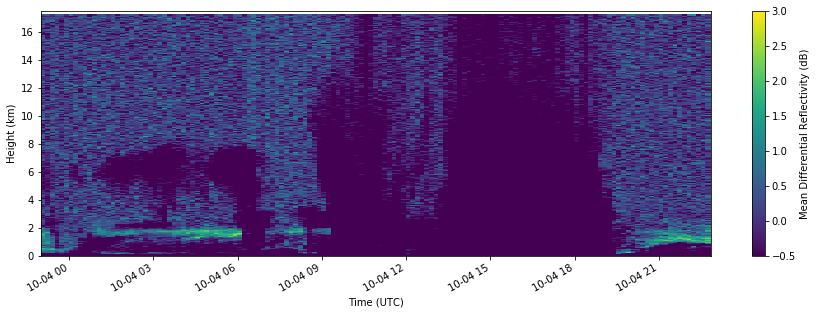

In [32]:
fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(times, qvps[0]['height']/1000.0, 
                    time_series['differential_reflectivity'].transpose(),
                    vmin = -.5, vmax = 3)
ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,17.5])
cb = plt.colorbar()
cb.set_label('Mean Differential Reflectivity (dB)')

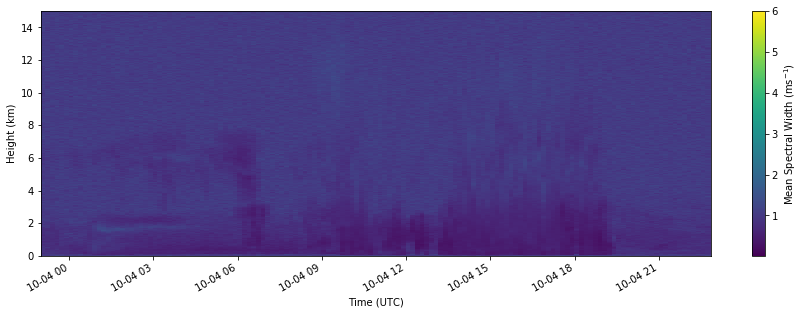

In [33]:
times.sort()
fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(times, qvps[0]['height']/1000.0, 
                    time_series['spectrum_width'].transpose(), 
                    vmax = 6)
ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,15])
cb = plt.colorbar()
cb.set_label('Mean Spectral Width (ms$^{-1}$)')

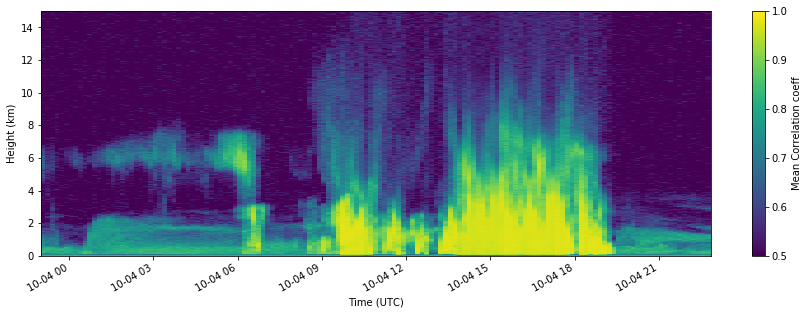

In [24]:
times.sort()
fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(times, qvps[0]['height']/1000.0, 
                    time_series['cross_correlation_ratio'].transpose(), vmin =0.5, vmax = 1.)
ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,15])
cb = plt.colorbar()
cb.set_label('Mean Correlation coeff')

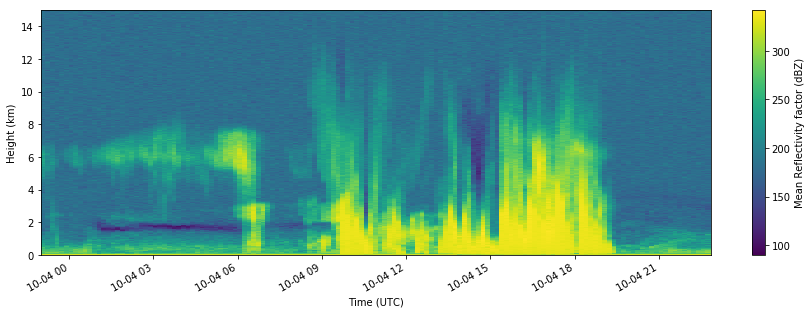

In [25]:
fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(times, qvps[0]['height']/1000.0, 
                    time_series['differential_phase'].transpose())#,
                    #vmin = 60, vmax = 100)
ax = plt.gca()
ax.xaxis_date()
#Magically deal with time!
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,15])
cb = plt.colorbar()
cb.set_label('Mean Reflectivity factor (dBZ)')